# EVS-POT
Use a function to map the (DH0, n_sigma) to 1D and estimate the probability.


## Read and plot

In [35]:
!ls /cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/

bf_mc_all.csv			  h0_mc_all.csv
bf_mc_all_scatter.csv		  h0_mc_all_full.csv
bf_mc_zcos.csv			  h0_mc_joint_all.csv
bf_truth.csv			  h0_mc_joint_scatter_all.csv
concatenated_fit_all.csv	  h0_mc_scatter.csv
concatenated_fit_all_mc.csv	  h0_mc_zcos.csv
concatenated_fit_all_scatter.csv  scatter_LX-T_added_scatter.csv
h0_angle_constraint_mc.csv	  scatter_LX-T.csv
h0_angle_constraint_scan.csv	  scatter_M-T.csv
h0_angle_constraints.csv	  scatter_YSZ-T_added_scatter.csv
h0_direct_compare.csv		  scatter_YSZ-T.csv
h0_direct_compare_scatter.csv


In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import genpareto
from scipy.special import erfinv
import math
import matplotlib.pyplot as plt
import clusterfit as cf
plt.style.use('./nice.mplstyle')

# Set percentile for EVS threshold
percentile = 95

def calculate_sigma_p_value(proj, target_value):
    median = np.median(proj)
    sigma_84th = np.percentile(proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

# Function to calculate EVT p-value
def calculate_evt_p_value(proj, target_value, percentile):
    # Determine the threshold
    threshold = np.percentile(proj, percentile)
    exceedances = proj[proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    params = genpareto.fit(exceedances)

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(proj >= threshold) / len(proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(proj >= target_value) / len(proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_evt = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_evt


# The first projection function
def default_proj(y, n_sigma):
    return y - y / n_sigma


In [50]:
def __calc_and_plot():
    """ Interior function to avoid copy pasting the same procedure 100 times."""

    # Number of sigma deviation
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(x, target_value)
    print(f"Number of std deviation: p={p_value_sigma:.3g}\\,({sigma_deviation:.3g}\\sigma)")

    # Frequentist
    p_value_freq = np.sum(x > target_value)/len(x)
    n_sigma_freq = cf.n_sigma1d(p_value_freq)
    print(f'Frequentist:{np.sum(x > target_value)}/{len(x)} p={p_value_freq} ({n_sigma_freq})')

    # Calculate EVT p-value and sigma deviation
    p_value_evt, sigma_evt = calculate_evt_p_value(x, target_value, percentile=percentile)
    print(f"EVT p-value: p={p_value_evt:.3g}\\,({sigma_evt:.3g}\\sigma)")

    # Plotting results
    fig = plt.figure(figsize=(5, 3))
    plt.hist(x, bins=30, density=True, alpha=0.6, color='#7570b3', label='FLAMINGO')

    # Fit a GPD distribution
    threshold = np.percentile(x, percentile)
    exceedances = x[x > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Plot fitted distribution
    x_vals = np.linspace(threshold, x.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label='Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label='Threshold (90th Percentile)')

    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
                xy=(target_value, 0.2), xycoords='data',
                xytext=(target_value - 1, 0.2), textcoords='data',
                arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
                horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

    return fig

## Lx-T
z = 0.07, 0.10

In [51]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1100 - 410

/tmp/ipykernel_1672819/3646976485.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0.0225\,(2.28\sigma)
Frequentist:4/668 p=0.005988023952095809 (2.748436461412691)
EVT p-value: p=0.00582\,(2.76\sigma)


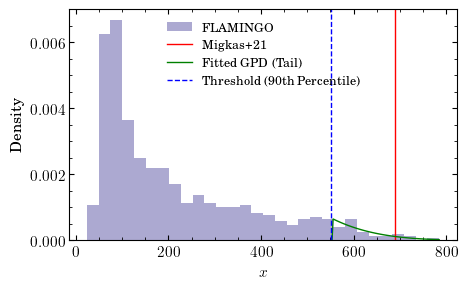

In [52]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

In [53]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1080 - 380

/tmp/ipykernel_1672819/1713371179.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0.0205\,(2.32\sigma)
Frequentist:3/668 p=0.004491017964071856 (2.841440868272963)
EVT p-value: p=0.00472\,(2.83\sigma)


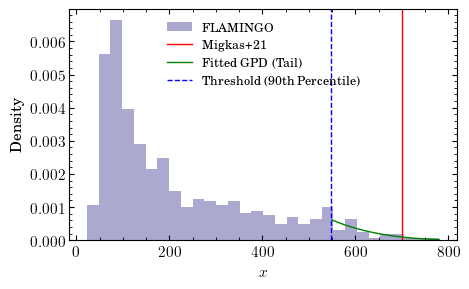

In [54]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Ysz-T
z = 0.07, 0.10

In [55]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1060 - 390

/tmp/ipykernel_1672819/392055772.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=1.59e-09\,(6.04\sigma)
Frequentist:0/667 p=0.0 (inf)
EVT p-value: p=0.000293\,(3.62\sigma)


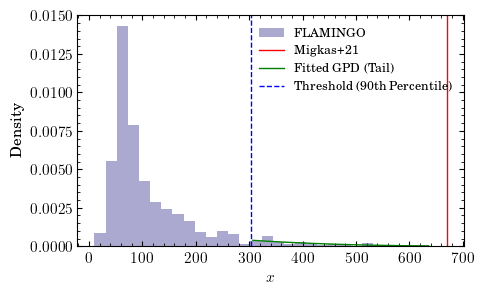

In [56]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

In [57]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1020 - 380

/tmp/ipykernel_1672819/4045150868.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=4.15e-09\,(5.88\sigma)
Frequentist:0/667 p=0.0 (inf)
EVT p-value: p=0.000545\,(3.46\sigma)


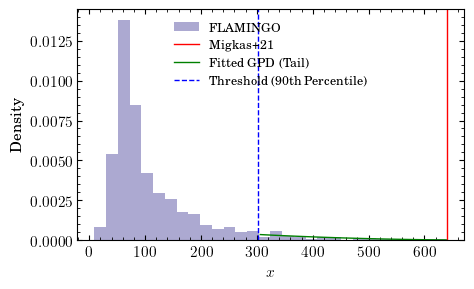

In [58]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Joint of LT, YT

In [59]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]

# Merge the data on Lightcone
u = pd.merge(left=uLT, right=uYT, on='Lightcone', suffixes=('_LT', '_YT'))

# Calculate the projection values
theta = cf.angular_separation(u['vlon_LT'].values, u['vlat_LT'].values,
    u['vlon_YT'].values, u['vlon_YT'].values) * np.pi/180
x = (u['ubf_LT'].values - u['ubf_err_lower_LT'].values) * np.cos(theta / 2) +\
    (u['ubf_YT'].values - u['ubf_err_lower_YT'].values) * np.cos(theta / 2)
x /= 2

# Define the target value
th = cf.angular_separation(318, -5, 254, -17) * np.pi/180
target_value = (1100 - 410) * np.cos(th / 2) + (1060 - 390) * np.cos(th / 2)
target_value /= 2

/tmp/ipykernel_1672819/3997380869.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
/tmp/ipykernel_1672819/3997380869.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]


Number of std deviation: p=8.86e-06\,(4.44\sigma)
Frequentist:1/667 p=0.0014992503748125937 (3.174828587449192)
EVT p-value: p=0.000378\,(3.55\sigma)


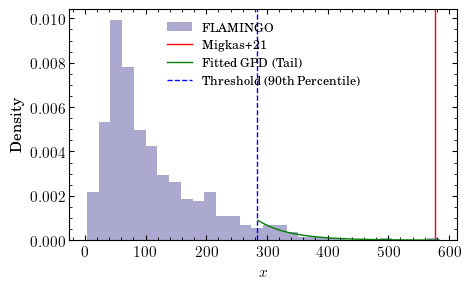

In [60]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Joint of LT YT

In [61]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all_scatter.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]

# Merge the data on Lightcone
u = pd.merge(left=uLT, right=uYT, on='Lightcone', suffixes=('_LT', '_YT'))

# Calculate the projection values
theta = cf.angular_separation(u['vlon_LT'].values, u['vlat_LT'].values,
    u['vlon_YT'].values, u['vlon_YT'].values) * np.pi/180
x = (u['ubf_LT'].values - u['ubf_err_lower_LT'].values) * np.cos(theta / 2) +\
    (u['ubf_YT'].values - u['ubf_err_lower_YT'].values) * np.cos(theta / 2)
x /= 2

# Define the target value
th = cf.angular_separation(257, -28, 322, -13) * np.pi/180
target_value = (1080-380) * np.cos(th / 2) + (1020-380) * np.cos(th / 2)
target_value /= 2

/tmp/ipykernel_1672819/515186172.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
/tmp/ipykernel_1672819/515186172.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]


Number of std deviation: p=9.13e-06\,(4.44\sigma)
Frequentist:1/667 p=0.0014992503748125937 (3.174828587449192)
EVT p-value: p=0.000414\,(3.53\sigma)


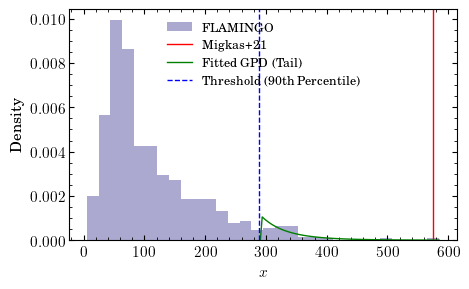

In [62]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()